<a href="https://colab.research.google.com/github/zrruziev/Deep_Learning_Practice/blob/main/Practice/simple_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Download [dataset](https://www.kaggle.com/kishanj/simple-object-detection) from kaggle


## First upload datasets from anywhere to "content" folder as dataset.zip
## Then move on...

In [168]:
import zipfile
import os

with zipfile.ZipFile("./dataset.zip", 'r') as zip_ref:
    zip_ref.extractall('./')

In [169]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as mpatches

In [170]:
# Define Directory 
images_directory = "./dataset/images"
annotations_directory="./dataset/annotations"

img_paths = sorted([os.path.join(images_directory, fname) for fname in os.listdir(images_directory) if fname.endswith(".jpg")])
label_paths = sorted([os.path.join(annotations_directory, fname) for fname in os.listdir(annotations_directory) if fname.endswith(".xml")])

k = len(img_paths)

data_list = []

for i in range(k):  
    annotation_file=label_paths[i]
    ds = BeautifulSoup(open(annotation_file).read(), "html.parser")

    # Iterating over each object elements
    for o in ds.find_all("object"):
        
        x_min = max(0, int(float(o.find("xmin").string)))
        y_min = max(0, int(float(o.find("ymin").string)))
        x_max = min(int(ds.find("width").string), int(float(o.find("xmax").string)))
        y_max = min(int(ds.find("height").string), int(float(o.find("ymax").string)))
        
        # in case the boundary goes above its limis, providing some restrictions.
        if x_min >= x_max or y_min >= y_max:
            continue
        elif x_max <= x_min or y_max <= y_min:
            continue
        
        sample = [str(img_paths[i]), x_min, y_min, x_max, y_max]
        
        data_list.append(sample)

data = pd.DataFrame(data_list)
print(data)

                                0   1    2    3    4
0    ./dataset/images/a (100).jpg  38   54  179  173
1    ./dataset/images/a (101).jpg  58   14  155  117
2    ./dataset/images/a (102).jpg  86   18  182  125
3    ./dataset/images/a (103).jpg  23   16  120  115
4    ./dataset/images/a (104).jpg  33   30  166  173
..                            ...  ..  ...  ...  ...
97    ./dataset/images/a (95).jpg  68   71  222  218
98    ./dataset/images/a (96).jpg  39   44  221  218
99    ./dataset/images/a (97).jpg  81    1  192  121
100   ./dataset/images/a (98).jpg  18    1  103  103
101   ./dataset/images/a (99).jpg  24  118  119  217

[102 rows x 5 columns]


In [171]:
data.head()

,0,1,2,3,4
0,./dataset/images/a (100).jpg,38,54,179,173
1,./dataset/images/a (101).jpg,58,14,155,117
2,./dataset/images/a (102).jpg,86,18,182,125
3,./dataset/images/a (103).jpg,23,16,120,115
4,./dataset/images/a (104).jpg,33,30,166,173


xmin = 38 , ymin = 54 , xmax = 179 , ymax = 173




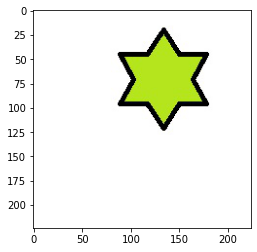

In [172]:
img = plt.imread(data[0][0])
plt.imshow(img)
print('xmin =', data[1][0], ', ymin =',data[2][0],', xmax =',data[3][0],', ymax =',data[4][0])
print('\n')

In [173]:
print(img.shape)

(224, 224, 3)


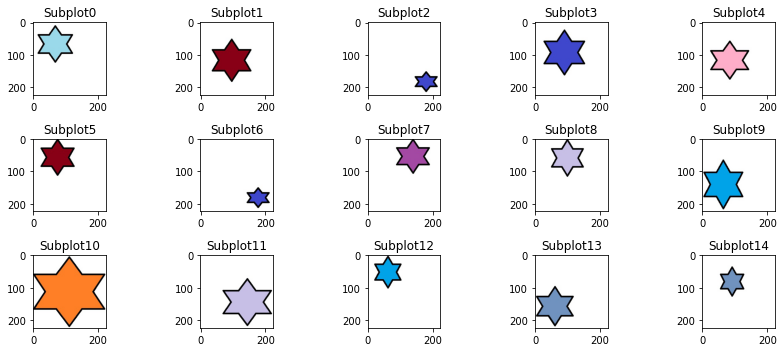

In [174]:
width=5
height=5
rows = 3
cols = 5
axes=[]
fig=plt.figure(figsize=(12, 5))
for a in range(rows*cols):
    c = np.random.randint(100)
    img = plt.imread(data[0][c])
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(img)
fig.tight_layout()    
plt.show()

In [175]:
def cm(xmin, xmax):
  return (xmin+xmax)/2

data['cx'] = data.apply(lambda r:cm(r[1],r[3]), axis=1) 
data['cy'] = data.apply(lambda r:cm(r[2],r[4]), axis=1)  

data.head()

,0,1,2,3,4,cx,cy
0,./dataset/images/a (100).jpg,38,54,179,173,108.5,113.5
1,./dataset/images/a (101).jpg,58,14,155,117,106.5,65.5
2,./dataset/images/a (102).jpg,86,18,182,125,134.0,71.5
3,./dataset/images/a (103).jpg,23,16,120,115,71.5,65.5
4,./dataset/images/a (104).jpg,33,30,166,173,99.5,101.5


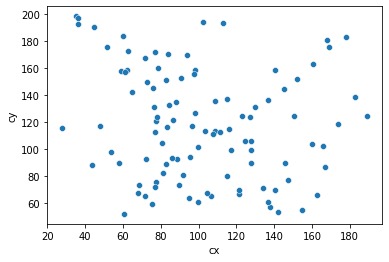

In [176]:
sns.scatterplot(data=data, x="cx", y="cy")

In [177]:
def cm(xmin, ymin, xmax, ymax):
    w = xmax - xmin
    h = ymax - ymin 
    return (h+w)/2

data['size'] = data.apply(lambda r:cm(r[1],r[2],r[3],r[4]), axis=1) 

data.head()

,0,1,2,3,4,cx,cy,size
0,./dataset/images/a (100).jpg,38,54,179,173,108.5,113.5,130.0
1,./dataset/images/a (101).jpg,58,14,155,117,106.5,65.5,100.0
2,./dataset/images/a (102).jpg,86,18,182,125,134.0,71.5,101.5
3,./dataset/images/a (103).jpg,23,16,120,115,71.5,65.5,98.0
4,./dataset/images/a (104).jpg,33,30,166,173,99.5,101.5,138.0


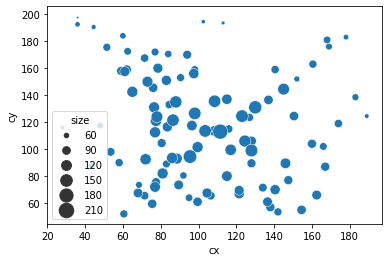

In [178]:
sns.scatterplot(data=data, x="cx", y="cy", size = 'size', sizes=(0, 224))

In [179]:
def proc_image(path, xmin, ymin, xmax, ymax):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float64)
    return image/255.0, (xmin, ymin, xmax, ymax)

In [180]:
np.random.seed(127)
bs = 16 #batch size
valid_mask = np.random.rand(len(data)) < 0.2
val = data[valid_mask]
train = data[~valid_mask]

In [181]:
dataset = tf.data.Dataset.from_tensor_slices((train[0].values, train[1].values, train[2].values ,train[3].values, train[4].values))
dataset = dataset.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(241).cache().repeat().batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((val[0].values, val[1].values, val[2].values, val[3].values, val[4].values))
dataset_valid = dataset_valid.map(proc_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(241).cache().batch(bs).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

steps_per_epoch_train = len(train) // bs
validation_steps = len(val) // bs

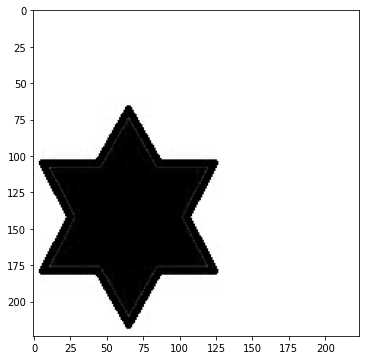

In [182]:
tf.keras.backend.clear_session()
datasetGen = iter(dataset)
batch2 = next(datasetGen)
img = np.array(batch2[0][0],dtype='float32')
# print(np.array(batch2[1],dtype='float32'))
plt.figure(figsize=(6,6))
plt.imshow(img[:,:,0],cmap='gray')

In [183]:
# Model Setup
x0 = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2), activation=tf.nn.relu)(x0)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(4,4), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(6,6), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(7,7), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(8,8), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(9,9), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(10,10), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(15,15), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(20,20), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(25,25), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(30,30), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(40,40), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(45,45), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), activation=tf.nn.relu)(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)

x = tf.keras.layers.Dense(256, activation=tf.nn.relu)(x)
x =tf.keras.layers.Dropout(0.2)(x)

x1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x1 =tf.keras.layers.Dropout(0.2)(x1)
y1 = tf.keras.layers.Dense(1, activation="linear", name="x_min")(x1)

x2 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x2 =tf.keras.layers.Dropout(0.2)(x2)
y2 = tf.keras.layers.Dense(1, activation="linear", name="y_min")(x2)

x3 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x3 =tf.keras.layers.Dropout(0.2)(x3)
y3 = tf.keras.layers.Dense(1, activation="linear", name="x_max")(x3)

x4 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
x4 =tf.keras.layers.Dropout(0.2)(x4)
y4 = tf.keras.layers.Dense(1, activation="linear", name="y_max")(x4)

model = tf.keras.Model(inputs=x0, outputs=[y1, y2, y3, y4])
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss=['mse','mse','mse','mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 223, 223, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 221, 221, 32  18464       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


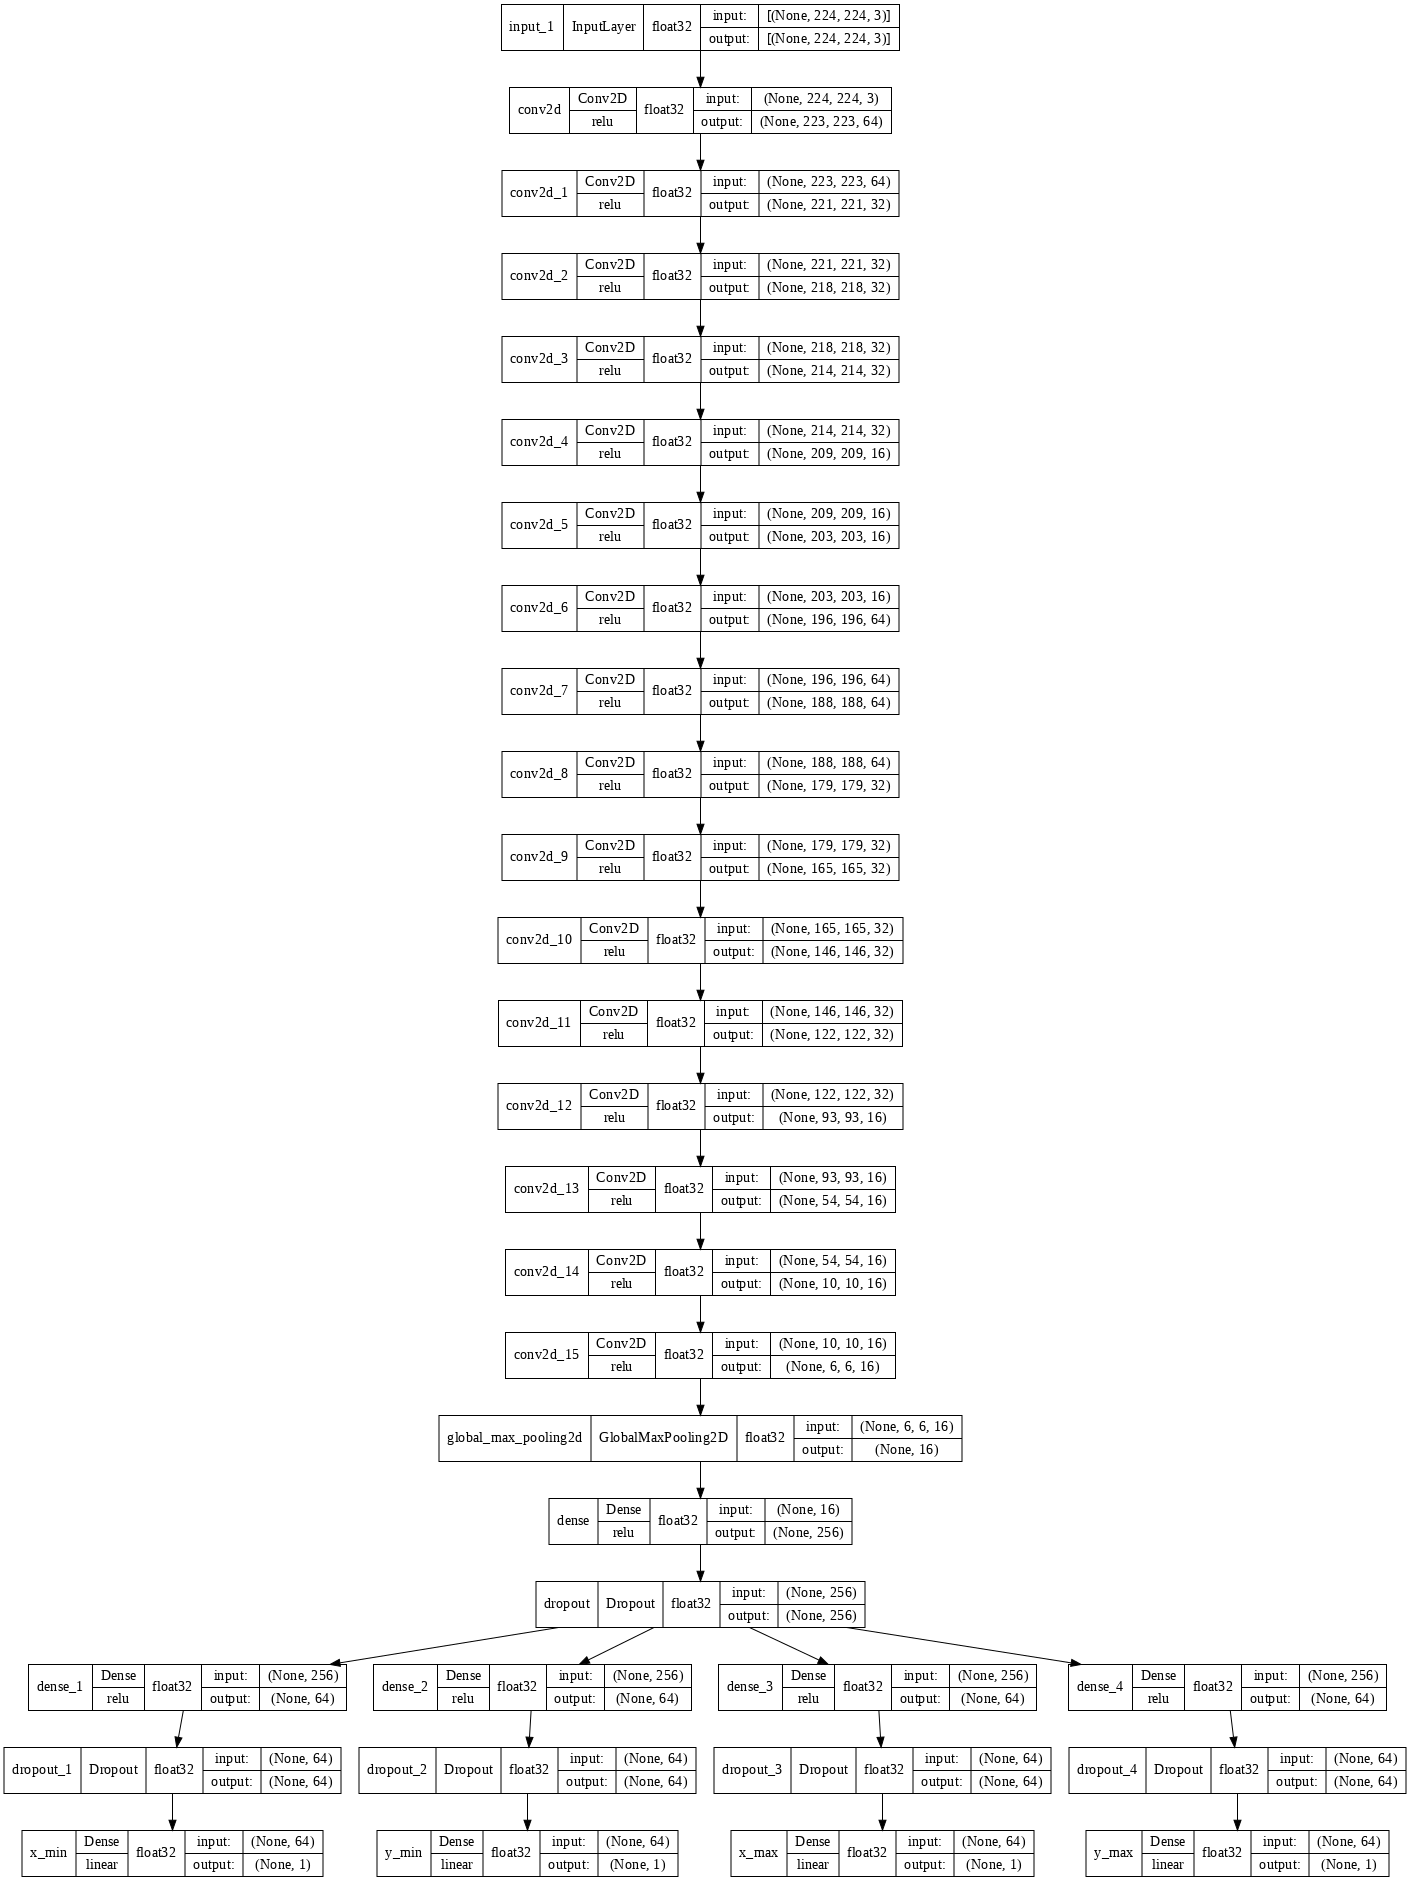

In [184]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, dpi=72, show_layer_activations=True)

In [185]:
hist = model.fit(dataset,epochs = 100,steps_per_epoch=steps_per_epoch_train, validation_data=dataset_valid, validation_steps=validation_steps)

Epoch 1/100
4/4 [==============================] - 7s 1s/step - loss: 68318.4375 - x_min_loss: 4277.6875 - y_min_loss: 5515.5718 - x_max_loss: 27245.2559 - y_max_loss: 31279.9258 - val_loss: 67099.9688 - val_x_min_loss: 1629.7681 - val_y_min_loss: 5934.2783 - val_x_max_loss: 23733.6133 - val_y_max_loss: 35802.3125
Epoch 2/100
4/4 [==============================] - 4s 1s/step - loss: 89060.1094 - x_min_loss: 14604.0693 - y_min_loss: 20763.8750 - x_max_loss: 27546.7578 - y_max_loss: 26145.4023 - val_loss: 51129.1406 - val_x_min_loss: 3484.9346 - val_y_min_loss: 22793.2871 - val_x_max_loss: 2697.1729 - val_y_max_loss: 22153.7461
Epoch 3/100
4/4 [==============================] - 4s 1s/step - loss: 55996.8984 - x_min_loss: 2950.2378 - y_min_loss: 11699.4062 - x_max_loss: 15790.8848 - y_max_loss: 25556.3672 - val_loss: 66431.3672 - val_x_min_loss: 1600.9224 - val_y_min_loss: 5921.0161 - val_x_max_loss: 23513.0684 - val_y_max_loss: 35396.3594
Epoch 4/100
4/4 [==============================] 

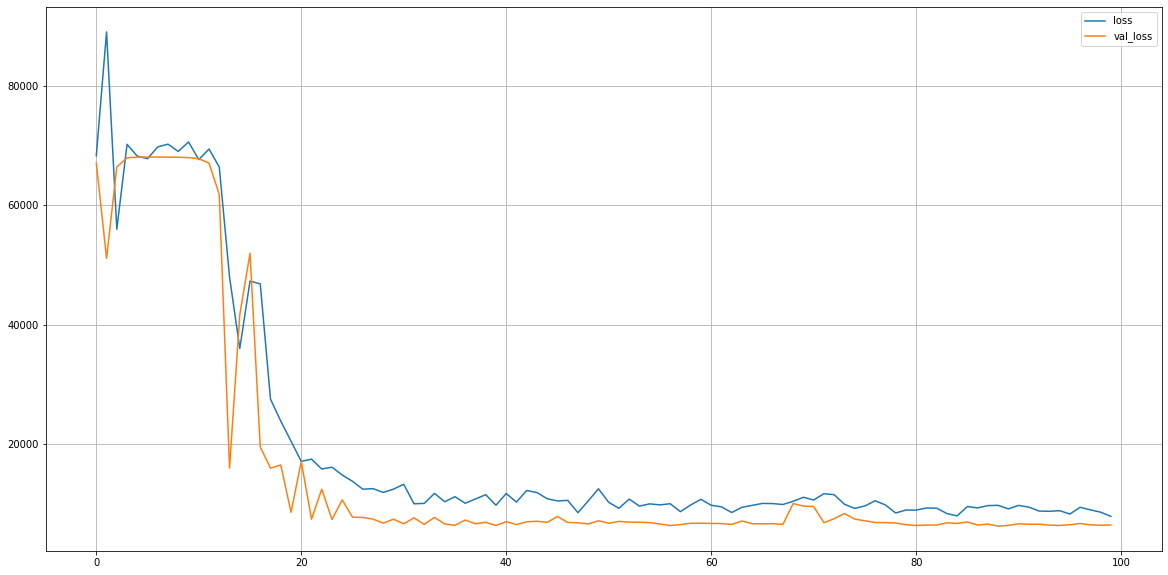

In [186]:
plt.figure(figsize=(20,10))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.grid(True)
plt.legend()

raw_result: [array([[45.946175]], dtype=float32), array([[46.216053]], dtype=float32), array([[135.46217]], dtype=float32), array([[147.80408]], dtype=float32)]

x_min = 45, y_min = 46, w = 135, h = 147



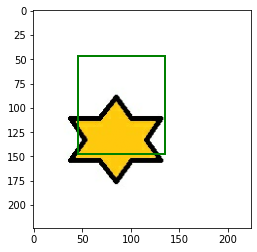

In [199]:
path = "./dataset/images/a (15).jpg"
image = tf.io.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.cast(image, tf.float64)
image = image/255.0
res = model.predict(tf.expand_dims(image,0))

w = res[2] - res[0]
h = res[3] - res[1]
rect=mpatches.Rectangle((res[0],res[1]),w,h, fill = False,color = "green",linewidth = 2)
print(f'raw_result: {res}')
print(f'\nx_min = {int(res[0][0][0])}, y_min = {int(res[1][0][0])}, w = {int(res[2][0][0])}, h = {int(res[3][0][0])}\n')
# pure_output = tf.squeeze(res)
# print(pure_output)
plt.imshow(image)
plt.gca().add_patch(rect)